# README
- [HomeCreditRisk : Extensive EDA + Baseline Model JP | Kaggle](https://www.kaggle.com/osciiart/homecreditrisk-extensive-eda-baseline-model-jp)
- [HomeCreditRisk: Extensive EDA + Baseline [0.772] | Kaggle](https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772)
    - これが本家


In [1]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')


%matplotlib inline
%autoreload 2

/Users/mohira/src/github.com/mohira/ml-materials/.venv/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# EDA: Application(ローン申込書)
- 各行が1つのローンを示す
- 行数: 307,511
- 列数: 122
- TARGET変数: クライアントが支払いの困難を抱えていたかどうか
    - 1: 遅れた
    - 2: 間に合った
    - ローンの最初のY分割払いの少なくとも1回で、クライアントがX日を超えて支払いを遅らせたことを意味します。
    - そのような場合は1とマークされ、他のすべての場合は0とマークされます。


## Application Train の概観

In [2]:
app_train = pd.read_csv('input/application_train.csv')

app_train.head()  # 最初の5行を表示

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [3]:
app_train.shape

(307511, 122)

## 目的変数の分布
- 目的変数をみる
    - 1: 支払が困難なクライアント = クライアントが最初のY回の分割払いの内に少なくとも一回でX日以上延滞していた場合
    - 0: それ以外の場合
- 非常に不均衡
    - 0: 92%
    - 1: 8%


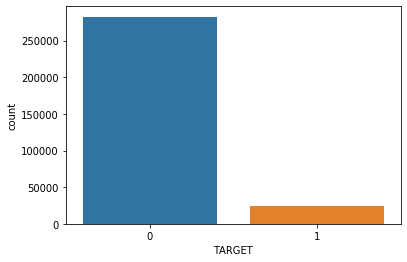

In [4]:
sns.countplot(app_train['TARGET'])

In [5]:
# 割合をみる
app_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

##  どの性別、どの契約タイプがローンを申し込んでいるか

### 性別(CODE_GENDER)
- 女性が多く、男性が少ない(202448 vs 105059)
- MEMO: 女性が多いってのはどういうローンなんだろうね？ 
- MEMO: 男性の方が多いと思ってた(家とかは大体男性だと思う)
- MEMO: 何のための融資なのかはヒントになるかもしれない

In [6]:
app_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Text(0.5, 1.0, 'Gender')

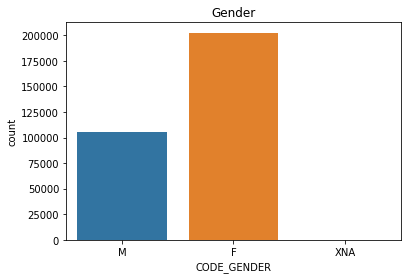

In [7]:
sns.countplot(app_train['CODE_GENDER'])
plt.title('Gender')

#### 性別と目的変数
- MEMO: 女性の方がデフォルト率が高いので、性別は効くかも？

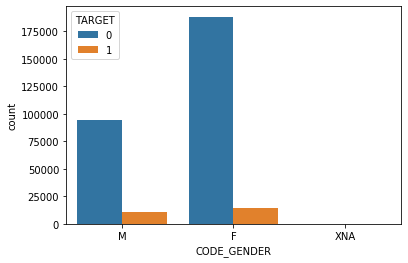

In [8]:
sns.countplot(app_train['CODE_GENDER'],
              hue=app_train['TARGET'])

In [9]:
default_rate_female = app_train[app_train['CODE_GENDER']
                                == 'F']['TARGET'].mean()
default_rate_male = app_train[app_train['CODE_GENDER'] == 'M']['TARGET'].mean()

print(f'デフォルト率(女性): {100 * default_rate_female:.2f}%')
print(f'デフォルト率(男性): {100 * default_rate_male:.2f}%')

デフォルト率(女性): 7.00%
デフォルト率(男性): 10.14%


### 契約タイプの分布(NAME_CONTRACT_TYPE)
- 契約のタイプ
    - キャッシュ: Cash loans: 90%
    - リボ払い: Revolving loans    10%
- リボ払いはかなり少ないね
- MEMO: リボ払いする時点で何かありそう。リボ払いを選択するのはどんな人？
        - 直近の金に困っている人 / 金融リテラシーの低い人
        - 返済計画が甘いので、遅延が多そうに思える

In [10]:
app_train['NAME_CONTRACT_TYPE'].value_counts(normalize=True)

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

Text(0.5, 1.0, 'Contact type')

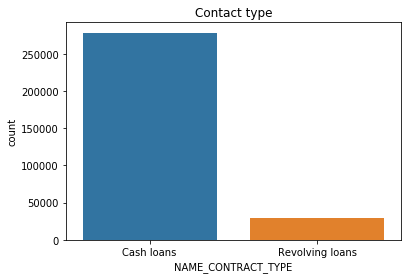

In [11]:
sns.countplot(app_train['NAME_CONTRACT_TYPE'])
plt.title('Contact type')

#### 契約タイプと目的変数
- MEMO: ここから分かることはあまりない？
- MEMO: デフォルト率でみると、キャッシュの方が高いけど、N数に大きな開きがあるので、なんとも。

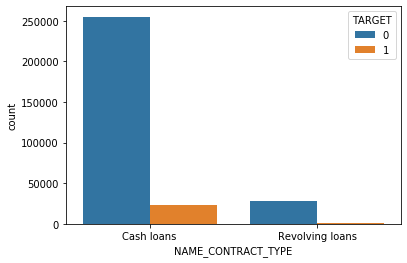

In [12]:
sns.countplot(app_train['NAME_CONTRACT_TYPE'],
              hue=app_train['TARGET'])

In [13]:
default_rate_cash = app_train[app_train['NAME_CONTRACT_TYPE']
                              == 'Cash loans']['TARGET'].mean()
default_rate_revoliving = app_train[app_train['NAME_CONTRACT_TYPE']
                                    == 'Revolving loans']['TARGET'].mean()

print(f'デフォルト率(キャッシュ): {100 * default_rate_cash:.2f}%')
print(f'デフォルト率(リボ払い): {100 * default_rate_revoliving:.2f}%')

デフォルト率(キャッシュ): 8.35%
デフォルト率(リボ払い): 5.48%


## 土地の所有と車の所有
- MEMO: どこの国のデータなのかを考えるとなにか見つかるかも？
- MEMO: 日本ではないので、別のドメイン知識がありそう

### 土地の所有 FLAG_OWN_REALTY
- 値は2種類
    - Y: 所有している
    - N: 所有していない
- 所有している人のほうが多い
    - 69% : 31%
- MEMO: TARGETとの関連性は微妙

In [14]:
app_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

In [15]:
app_train['FLAG_OWN_REALTY'].value_counts(normalize=True)

Y    0.693673
N    0.306327
Name: FLAG_OWN_REALTY, dtype: float64

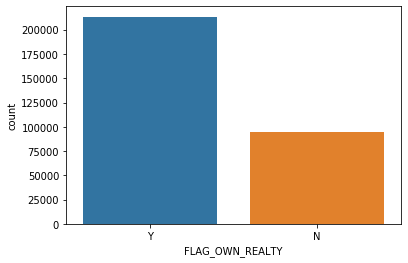

In [16]:
sns.countplot(app_train['FLAG_OWN_REALTY'],
              order=['Y', 'N'])

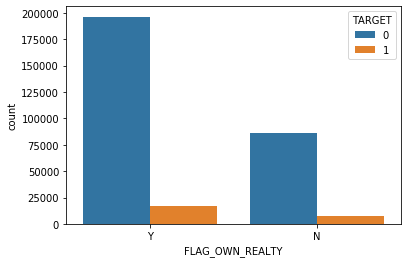

In [17]:
sns.countplot(app_train['FLAG_OWN_REALTY'],
              hue=app_train['TARGET'],
              order=['Y', 'N'])

### 車の所有
- 値は2種類
    - Y: 所有している
    - N: 所有していない
- 所有**していない**人のほうが多い
    - 35% : 65%
- MEMO: TARGETとの関連性は微妙

In [18]:
app_train['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [19]:
app_train['FLAG_OWN_CAR'].value_counts(normalize=True)

N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64

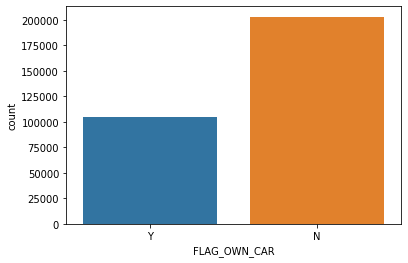

In [20]:
sns.countplot(app_train['FLAG_OWN_CAR'],
              order=['Y', 'N'])

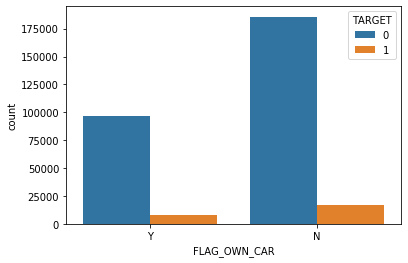

In [21]:
sns.countplot(app_train['FLAG_OWN_CAR'],
              hue=app_train['TARGET'],
              order=['Y', 'N'])

## 同伴者・収入形態¶

### 同伴者: NAME_TYPE_SUITE
- 同伴者 (NAME_TYPE_SUITE): 借入申請書提出時に同伴した人物
- 値は7種類
    - Unaccompanied      248526
    - Family              40149
    - Spouse, partner     11370
    - Children             3267
    - Other_B              1770
    - Other_A               866
    - Group of people       271
- MEMO: 同伴者の属性によって、返済変わりそう
    - e.g. 家族といくと楽観的になりやすい(返済が厳しくても借りてしまう)など
    - e.g. 夫婦でいくと、より悲観的になりやすい(返済できるかどうかの判断が厳しい)など

In [22]:
app_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [23]:
name_types_order_desc = app_train['NAME_TYPE_SUITE'].value_counts().index

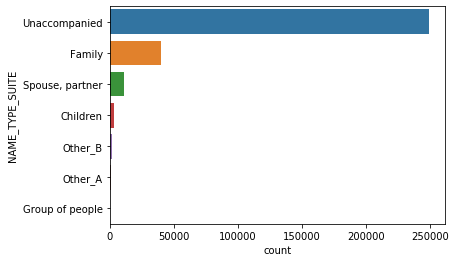

In [24]:
sns.countplot(y=app_train['NAME_TYPE_SUITE'],
              order=name_types_order_desc)

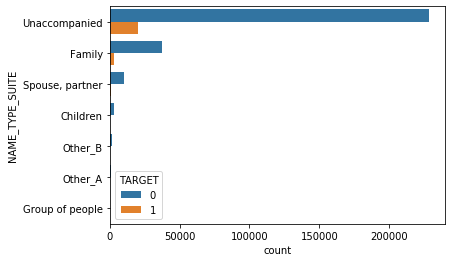

In [25]:
sns.countplot(y=app_train['NAME_TYPE_SUITE'],
              order=name_types_order_desc,
              hue=app_train['TARGET'])

### 収入形態: NAME_INCOME_TYPE
- 値は8種類
    - Working                 158774
    - Commercial associate     71617
    - Pensioner(年金受給者)      55362
    - State servant            21703
    - Unemployed                  22
    - Student                     18
    - Businessman                 10
    - Maternity leave              5

In [26]:
app_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [27]:
name_income_order_desc = app_train['NAME_INCOME_TYPE'].value_counts().index

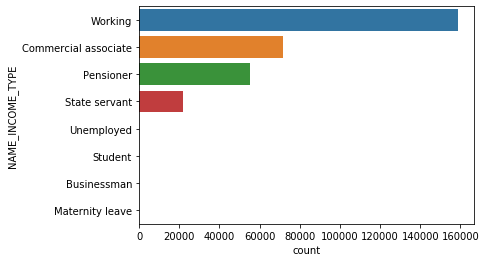

In [28]:
sns.countplot(y=app_train['NAME_INCOME_TYPE'],
              order=name_income_order_desc)

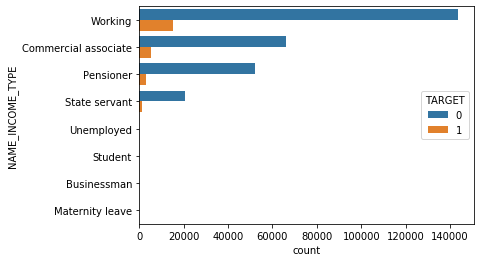

In [29]:
sns.countplot(y=app_train['NAME_INCOME_TYPE'],
              order=name_income_order_desc,
              hue=app_train['TARGET'])

## 婚姻状況・住居


### 婚姻状況
- 値は7種類
    - Married                 196432
    - Single / not married     45444
    - Civil marriage           29775
    - Separated                19770
    - Widow                    16088
    - Unknown                      2
- 結婚している人が大半

In [30]:
app_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [31]:
name_family_status_order_desc = app_train['NAME_FAMILY_STATUS'].value_counts(
).index

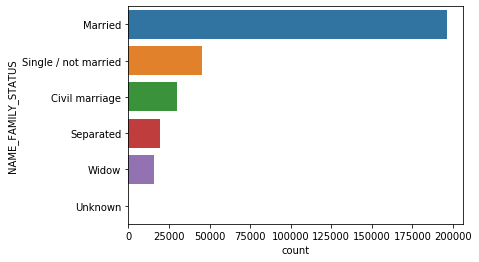

In [32]:
sns.countplot(y=app_train['NAME_FAMILY_STATUS'],
              order=name_family_status_order_desc)

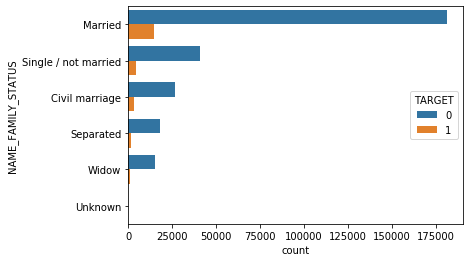

In [33]:
sns.countplot(y=app_train['NAME_FAMILY_STATUS'],
              order=name_family_status_order_desc,
              hue=app_train['TARGET'])

### 住居
- 値は5種類
    - House / apartment      272868
    - With parents            14840
    - Municipal apartment     11183
    - Rented apartment         4881
    - Office apartment         2617
    - Co-op apartment          1122
- 大半(85%)は一軒家からアパート
    - そもそも持ち家率が60%以上だったからね
- MEMO: 両親と同居とか公営住宅とかを分けているのはなんでだろうね？

In [34]:
app_train['NAME_HOUSING_TYPE'].value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

In [35]:
app_train['NAME_HOUSING_TYPE'].value_counts(normalize=True)

House / apartment      0.887344
With parents           0.048258
Municipal apartment    0.036366
Rented apartment       0.015873
Office apartment       0.008510
Co-op apartment        0.003649
Name: NAME_HOUSING_TYPE, dtype: float64

In [36]:
name_housing_type_order_desc = app_train['NAME_HOUSING_TYPE'].value_counts(
).index

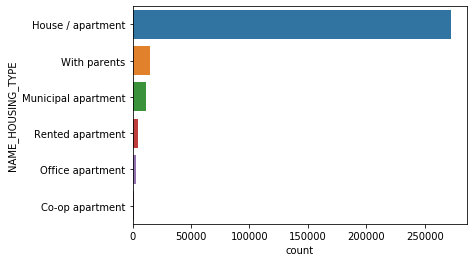

In [37]:
sns.countplot(y=app_train['NAME_HOUSING_TYPE'],
              order=name_housing_type_order_desc)

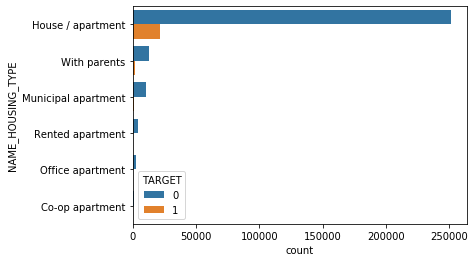

In [38]:
sns.countplot(y=app_train['NAME_HOUSING_TYPE'],
              order=name_housing_type_order_desc,
              hue=app_train['TARGET'])

## 教育
- 値は5種類
    - Secondary / secondary special    218391
    - Higher education                  74863
    - Incomplete higher                 10277
    - Lower secondary                    3816
    - Academic degree                     164
- 大半が中等教育    
- MEMO: 教育の程度と期日通りの返済    は関連がありそう

In [39]:
app_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [40]:
app_train['NAME_EDUCATION_TYPE'].value_counts(normalize=True)

Secondary / secondary special    0.710189
Higher education                 0.243448
Incomplete higher                0.033420
Lower secondary                  0.012409
Academic degree                  0.000533
Name: NAME_EDUCATION_TYPE, dtype: float64

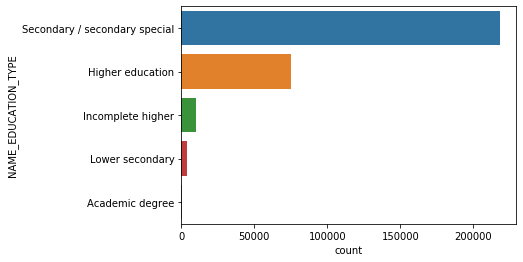

In [41]:
sns.countplot(y=app_train['NAME_EDUCATION_TYPE'])

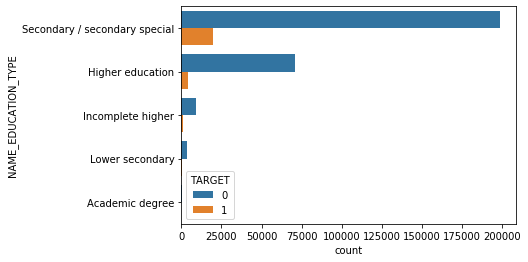

In [42]:
sns.countplot(y=app_train['NAME_EDUCATION_TYPE'],
              hue=app_train['TARGET'])

## 組織・業種¶

### 組織: クライアントが働いている組織
- MEMO: 結構よくわからない。仮説はあまり出てこない。

In [43]:
app_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

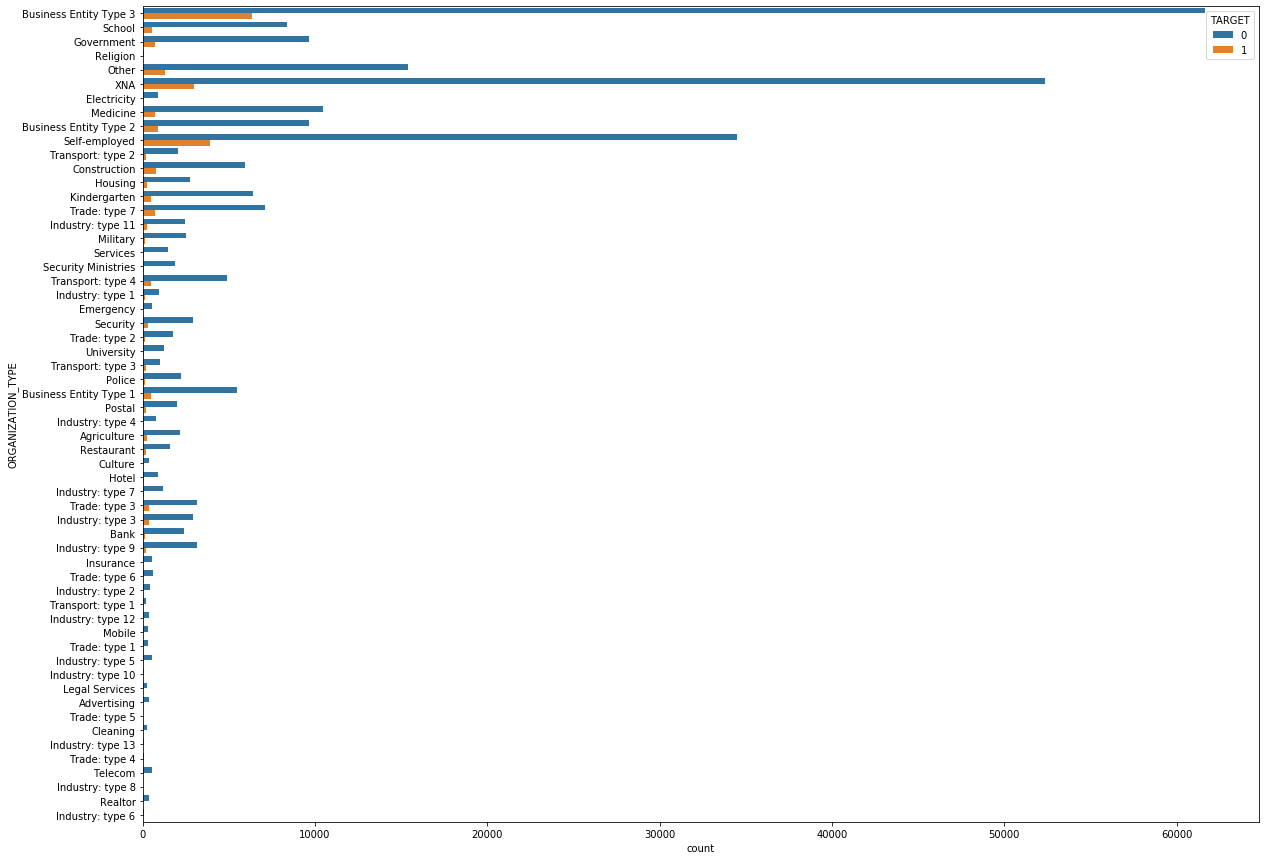

In [44]:
plt.figure(figsize=(20, 15))
sns.countplot(y=app_train['ORGANIZATION_TYPE'],
              hue=app_train['TARGET'])

### 業種: クライアントの業種

In [45]:
app_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

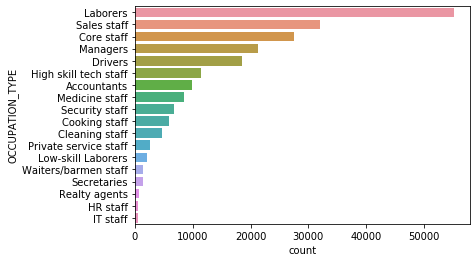

In [46]:
name_occupation_type_order_desc = app_train['OCCUPATION_TYPE'].value_counts(
).index

sns.countplot(y=app_train['OCCUPATION_TYPE'],
              order=name_occupation_type_order_desc)

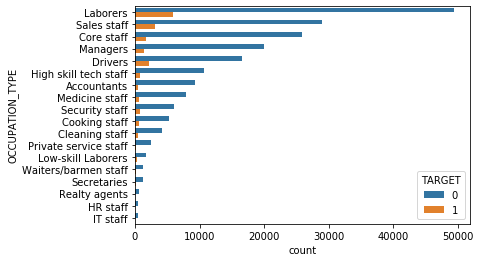

In [47]:
sns.countplot(y=app_train['OCCUPATION_TYPE'],
              order=name_occupation_type_order_desc,
              hue=app_train['TARGET'])

## 壁の種類・基礎の種類・家屋の種類の分布¶
- MEMO: 「家のランク」みたいなものが分かる → 収入というか階級？が分かる？

### 壁の種類

In [48]:
app_train['WALLSMATERIAL_MODE'].value_counts()

Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64

In [49]:
# 欠損が多い
app_train['WALLSMATERIAL_MODE'].isnull().sum()

156341

### 基礎の種類

In [50]:
app_train['FONDKAPREMONT_MODE'].value_counts()

reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64

In [51]:
# 欠損が多い
app_train['FONDKAPREMONT_MODE'].isnull().sum()

210295

### 家屋の種類

In [52]:
app_train['HOUSETYPE_MODE'].value_counts()

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64

In [53]:
# 欠損が多い
app_train['HOUSETYPE_MODE'].isnull().sum()

154297

## 借金額の分布

In [54]:
app_train['AMT_CREDIT'].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

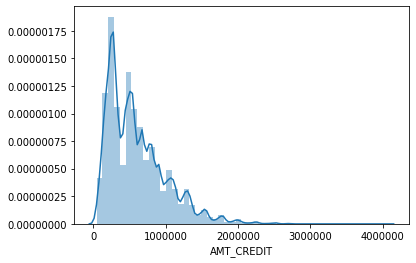

In [55]:
sns.distplot(app_train['AMT_CREDIT'])

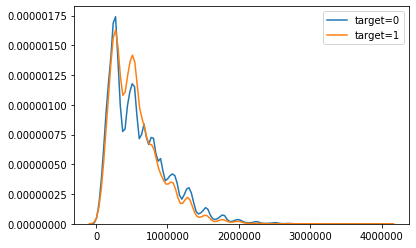

In [56]:
app_train_target0 = app_train[app_train['TARGET'] == 0]
app_train_target1 = app_train[app_train['TARGET'] == 1]

sns.kdeplot(app_train_target0['AMT_CREDIT'].dropna(), label='target=0')
sns.kdeplot(app_train_target1['AMT_CREDIT'].dropna(), label='target=1')

## 年金の分布: AMT_ANNUITY

In [57]:
app_train['AMT_ANNUITY'].isnull().sum()

12

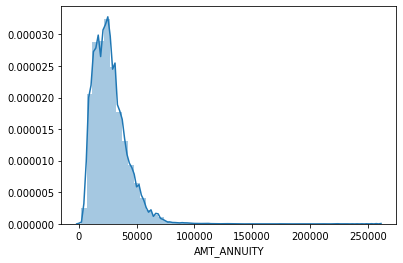

In [58]:
sns.distplot(app_train['AMT_ANNUITY'].dropna())

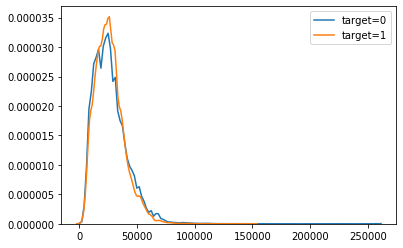

In [59]:
app_train_target0 = app_train[app_train['TARGET'] == 0]
app_train_target1 = app_train[app_train['TARGET'] == 1]

sns.kdeplot(app_train_target0['AMT_ANNUITY'].dropna(), label='target=0')
sns.kdeplot(app_train_target1['AMT_ANNUITY'].dropna(), label='target=1')

## 商品価格の分布
- 商品価格: ローンを組む目的である商品の価格

In [60]:
app_train['AMT_GOODS_PRICE'].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [61]:
app_train['AMT_GOODS_PRICE'].isnull().sum()

278

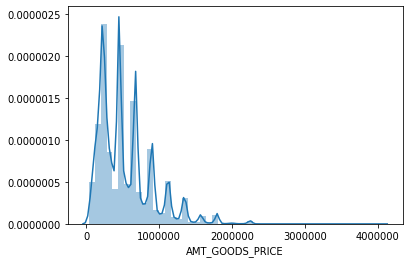

In [62]:
sns.distplot(app_train['AMT_GOODS_PRICE'].dropna())

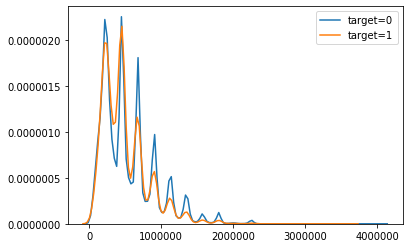

In [63]:
app_train_target0 = app_train[app_train['TARGET'] == 0]
app_train_target1 = app_train[app_train['TARGET'] == 1]

sns.kdeplot(app_train_target0['AMT_GOODS_PRICE'].dropna(), label='target=0')
sns.kdeplot(app_train_target1['AMT_GOODS_PRICE'].dropna(), label='target=1')

## 相対人口分布の分布
- 相対地域人口: 正規化されたクライアントが住んでいる地域の人口 (クライアントがより人口の多い地域に住んでいることを表す)
- MEMO: 人口の多さとローンを組む度合いは関係あるんかなあ？

In [64]:
app_train['REGION_POPULATION_RELATIVE'].isnull().sum()

0

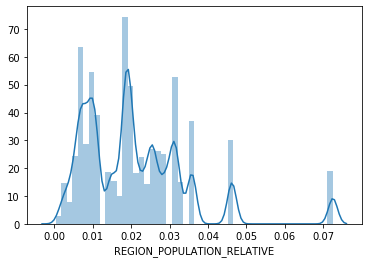

In [65]:
sns.distplot(app_train['REGION_POPULATION_RELATIVE'])

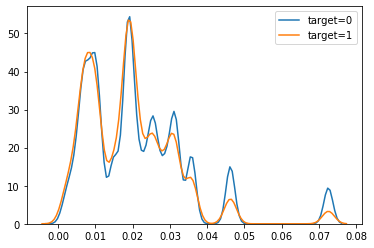

In [66]:
app_train_target0 = app_train[app_train['TARGET'] == 0]
app_train_target1 = app_train[app_train['TARGET'] == 1]

sns.kdeplot(app_train_target0['REGION_POPULATION_RELATIVE'], label='target=0')
sns.kdeplot(app_train_target1['REGION_POPULATION_RELATIVE'], label='target=1')

## 年齢の分布
- 年齢: クライアントが借入申請日の何日前に生まれたか
    - つまり、申請日時点での日齢ということ(365で割って、-1を掛ければ、申請日時点での年齢になる)
- MEMO: 層別に分布を見ると結構ちがうぞ！
    - 年齢が若いほうが、デフォルトしやすいように見える

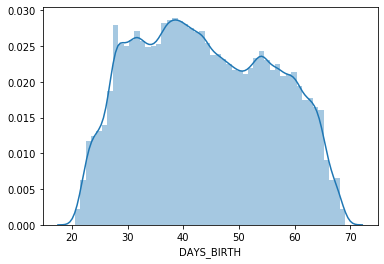

In [67]:
# 日齢に変換したうえでの分布
sns.distplot(app_train['DAYS_BIRTH'] / -365)

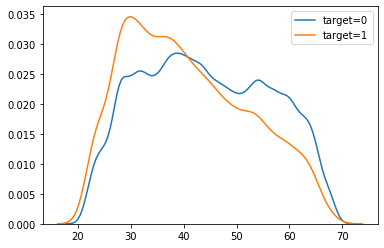

In [68]:
app_train_target0 = app_train[app_train['TARGET']==0]
app_train_target1 = app_train[app_train['TARGET']==1]

sns.kdeplot(app_train_target0['DAYS_BIRTH'] / -365, label='target=0')
sns.kdeplot(app_train_target1['DAYS_BIRTH'] / -365, label='target=1')

## 雇用日数の分布
- 雇用日数: クライアントが借入申請日の何日前から現在の仕事を始めたか

- MEMO: 雇用日数 == 現職の勤続日数が短い人のほうが多い
- MEMO: 雇用日数が短い人のほうがデフォルトしやすいようにみえる

In [69]:
# 365,243 は明らかにおかしい(1000年以上勤めていることになる)
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

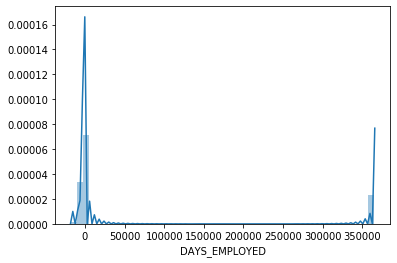

In [70]:
sns.distplot(app_train['DAYS_EMPLOYED'])

In [71]:
# 307,511件もある！
(app_train['DAYS_EMPLOYED']==365243).shape

(307511,)

In [72]:
# 365243を除外して、再度分布をみる
not_365243 = app_train[app_train['DAYS_EMPLOYED']!=365243][['TARGET', 'DAYS_EMPLOYED']]

# 最大値0は自然だ
# 最長の人で 17912日の勤続 == 約49年
not_365243['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

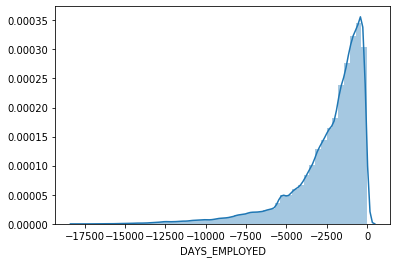

In [73]:
sns.distplot(not_365243['DAYS_EMPLOYED'])

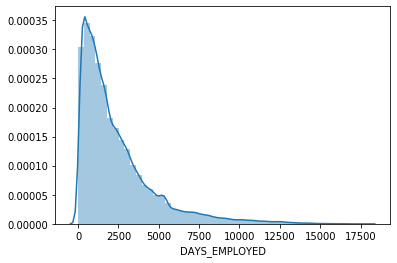

In [74]:
# マイナスだと判断しづらいので、勤続日数に直す
sns.distplot(not_365243['DAYS_EMPLOYED'] * -1)

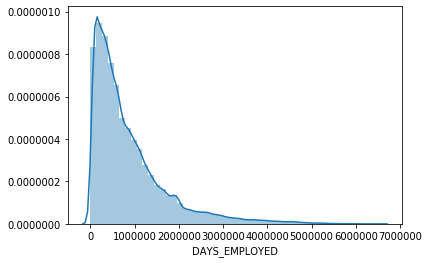

In [75]:
# 勤続年数に直す
sns.distplot(not_365243['DAYS_EMPLOYED'] * -365)

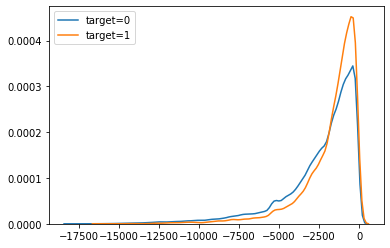

In [76]:
not_365243_target0 = not_365243[not_365243['TARGET']==0]
not_365243_target1 = not_365243[not_365243['TARGET']==1]

sns.kdeplot(not_365243_target0['DAYS_EMPLOYED'], label='target=0')
sns.kdeplot(not_365243_target1['DAYS_EMPLOYED'], label='target=1')

## 登録日の分布
- 登録日: クライアントが借入申請日の何日前に登録情報を更新したか

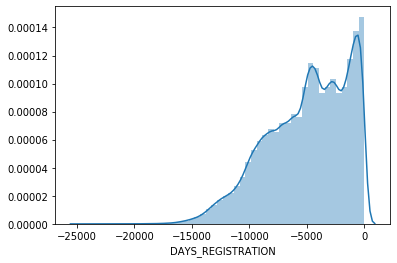

In [77]:
sns.distplot(app_train['DAYS_REGISTRATION'])

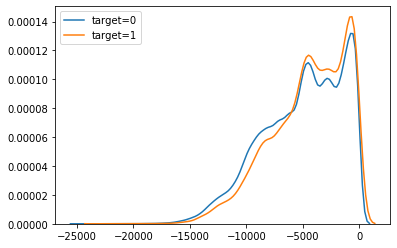

In [78]:
# 層別にみても分布に違いはなさそう
sns.kdeplot(app_train_target0['DAYS_REGISTRATION'], label='target=0')
sns.kdeplot(app_train_target1['DAYS_REGISTRATION'], label='target=1')

## 華族の人数

In [79]:
app_train['CNT_FAM_MEMBERS'].isnull().sum()

2

In [80]:
app_train['CNT_FAM_MEMBERS'].value_counts()

2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
16.0         2
12.0         2
20.0         2
11.0         1
13.0         1
15.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

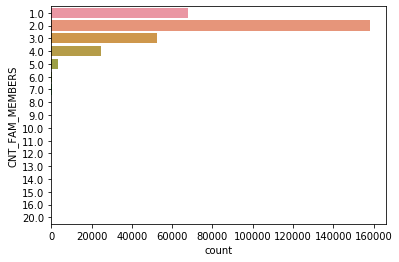

In [81]:
sns.countplot(y=app_train['CNT_FAM_MEMBERS'].dropna())

# 信用情報機関データのデータ探索¶
- 信用情報機関によって報告されている顧客の過去の他の金融機関で借入履歴。
- 顧客の借入申込日以前の借入回数と同じ行数の借入情報が含まれる。

## 信用情報機関データの概観(bureau.csv'))

In [82]:
app_bureau = pd.read_csv('input/bureau.csv')

In [83]:
app_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [84]:
app_bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [85]:
app_bureau.describe(include='object')

CREDIT_ACTIVE CREDIT_CURRENCY      CREDIT_TYPE
count        1716428         1716428          1716428
unique             4               4               15
top           Closed      currency 1  Consumer credit
freq         1079273         1715020          1251615

# 信用情報機関残高のデータ探索¶
- 信用情報機関の過去の借入の月間残高。
- このテーブルには、過去の借入についての各月の残高が1行ずつ記録されています。
- テーブルの各列には、ある借入のx月 (借入申請からxヶ月前) の債務状況の情報が含まれます。

## 信用情報機関残高データの概観

In [86]:
app_bureau_balance = pd.read_csv('input/bureau_balance.csv')

In [87]:
app_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [88]:
app_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [89]:
app_bureau_balance.describe()

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [90]:
app_bureau_balance.describe(include='object')

STATUS
count   27299925
unique         8
top            C
freq    13646993

In [91]:
app_bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

# クレジットカード残高のデータ探索¶
- 借入申請者の持つホーム・クレジット社製クレジットカードの各月の残高情報。
- このテーブルには、借入申請者の持つホーム・クレジット社製クレジットカード (消費者金融・キャッシュローン) の各月の残高が1行ずつ記録されています。
- テーブルの各列には、あるクレジットカードのx月 (借入申請からxヶ月前) の債務状況の情報が含まれます。

## クレジットカード残高データの概観

In [92]:
app_card_balance = pd.read_csv('input/credit_card_balance.csv')

In [93]:
app_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

In [94]:
app_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [95]:
app_card_balance.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

In [96]:
app_card_balance.describe(include='object')

NAME_CONTRACT_STATUS
count               3840312
unique                    7
top                  Active
freq                3698436

# 過去の借入申請書のデータ探索¶
- 借入申請者の持つホーム・クレジットに関する過去のPOSとキャッシュローンの各月の残高情報。
- テーブルの各列には、あるローンのx月 (借入申請からxヶ月前) の債務状況の情報が含まれます。 
- このテーブルには、ローン の各月の残高が1行ずつ記録されています。
- (訳注: よくわかりませんでした)

## 過去の借入申請書データの概観

In [97]:
pos_cash = pd.read_csv('input/POS_CASH_balance.csv')

In [98]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [99]:
pos_cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [100]:
pos_cash.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

# 過去の借入申請書のデータ探索
## 過去の借入申請書データの概観

In [102]:
previous_app = pd.read_csv('input/previous_application.csv')

In [103]:
previous_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

In [104]:
previous_app.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [105]:
previous_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

## 過去の借入申請書の契約状況の分布¶


In [106]:
previous_app['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [107]:
previous_app['NAME_CONTRACT_STATUS'].value_counts(normalize=True)

Approved        0.620747
Canceled        0.189388
Refused         0.174036
Unused offer    0.015828
Name: NAME_CONTRACT_STATUS, dtype: float64

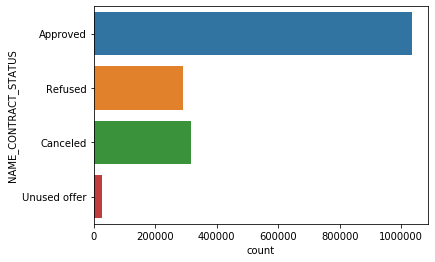

In [108]:
sns.countplot(y=previous_app['NAME_CONTRACT_STATUS'])

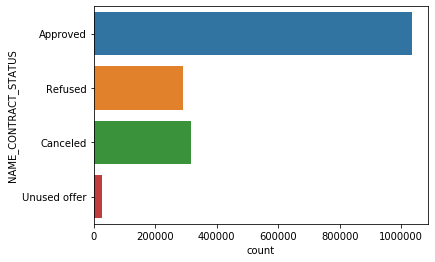

In [109]:
sns.countplot(y=previous_app['NAME_CONTRACT_STATUS'],
              )

In [110]:
previous_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [111]:
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

### 目的変数との関係
- MEMO: 過去のRefuseだったひとはデフォルト率高いのでは？

In [112]:
a = app_train[['SK_ID_CURR', 'TARGET']]
b = previous_app[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']]

# 全てに欠損はないので素直にInnderJOIN
c = pd.merge(left=a, right=b, how='inner', on='SK_ID_CURR')

c.head()

SK_ID_CURR  TARGET NAME_CONTRACT_STATUS
0      100002       1             Approved
1      100003       0             Approved
2      100003       0             Approved
3      100003       0             Approved
4      100004       0             Approved

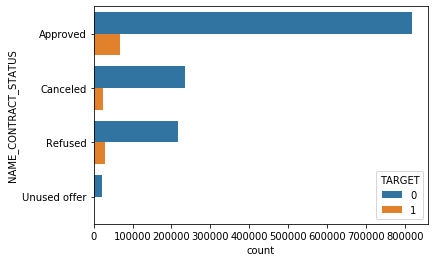

In [113]:
sns.countplot(y='NAME_CONTRACT_STATUS',
              hue='TARGET',
              data=c)

## 過去の借入申請書の同伴者の分布¶

In [114]:
previous_app['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [115]:
previous_app['NAME_TYPE_SUITE'].isnull().sum()

820405

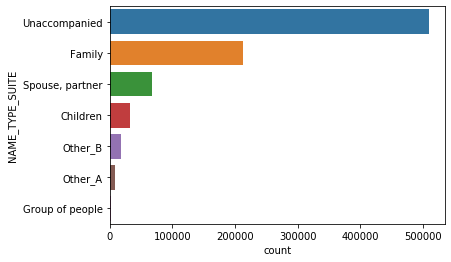

In [116]:
sns.countplot(y=previous_app['NAME_TYPE_SUITE'].dropna(),
             order=previous_app['NAME_TYPE_SUITE'].value_counts().index)

### 過去の申込みと、現在の申込みの分布はにているか？
- 傾向は似ているね <--- だから何？
    - 過去のデフォルト率とか見れたら、使えそう？

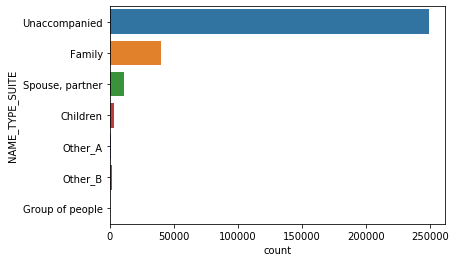

In [117]:
sns.countplot(y=app_train['NAME_TYPE_SUITE'])

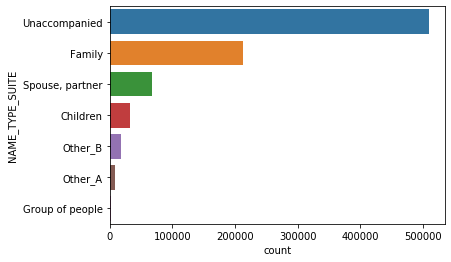

In [118]:
sns.countplot(y=previous_app['NAME_TYPE_SUITE'].dropna(),
             order=previous_app['NAME_TYPE_SUITE'].value_counts().index)

### 過去の申込みは現在の申込みの予測に使えるのではないか？
- 現在の申込みの方が情報量が多い → 近似するには無理がありそう？
- とはいえ、共通カラムもあるし、過去にしかない情報もあるのでなにかあるかも？

In [119]:
from pprint import pprint
prev_app_cols = set(previous_app.columns)
now_app_cols = set(app_train.columns)

In [120]:
# 共通のカラム
cols_and = prev_app_cols & now_app_cols
print(f'共通のカラム {len(cols_and)}')
pprint(cols_and)

共通のカラム 8
{'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'SK_ID_CURR',
 'WEEKDAY_APPR_PROCESS_START'}


In [121]:
prev_only = prev_app_cols - now_app_cols
print(f'過去のみ {len(prev_only)}')
pprint(prev_only)

過去のみ 29
{'AMT_APPLICATION',
 'AMT_DOWN_PAYMENT',
 'CHANNEL_TYPE',
 'CNT_PAYMENT',
 'CODE_REJECT_REASON',
 'DAYS_DECISION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_TERMINATION',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CLIENT_TYPE',
 'NAME_CONTRACT_STATUS',
 'NAME_GOODS_CATEGORY',
 'NAME_PAYMENT_TYPE',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'NFLAG_INSURED_ON_APPROVAL',
 'NFLAG_LAST_APPL_IN_DAY',
 'PRODUCT_COMBINATION',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'SELLERPLACE_AREA',
 'SK_ID_PREV'}


In [122]:
now_only = now_app_cols - prev_app_cols 
print(f'現在のみ {len(now_only)}')
pprint(now_only)

現在のみ 114
{'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'EMERGENCYSTATE_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT

## 過去の借入申請書の顧客タイプ¶
- MEMO: リピーターがいるのか。ほう
- MEMO: リピーターかどうかを判定できるならCVでは除外したほうがいいかもしれないね
- リピーターが多い

In [123]:
previous_app['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

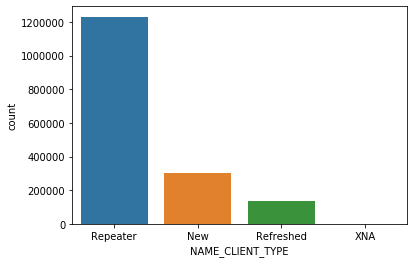

In [124]:
sns.countplot(previous_app['NAME_CLIENT_TYPE'])

### リピーターのデフォルト率

In [125]:
a = app_train[['SK_ID_CURR', 'TARGET']]
b = previous_app[['SK_ID_CURR', 'NAME_CLIENT_TYPE']]

# 全てに欠損はないので素直にInnderJOIN
c = pd.merge(left=a, right=b, how='inner', on='SK_ID_CURR')

d = c.groupby('NAME_CLIENT_TYPE').agg({'TARGET': [lambda x: np.mean(x).round(4) * 100, 'count']})

d.rename(columns={'<lambda>': 'default_rate'}, inplace=True)

d

TARGET         
                 <lambda_0>    count
NAME_CLIENT_TYPE                    
New                    8.99   259540
Refreshed              7.34   114936
Repeater               8.71  1037682
XNA                    9.92     1543

## チャネルタイプ
- チャネルタイプ: どの方法で借入申請書を受け取ったか


In [126]:
previous_app['CHANNEL_TYPE'].value_counts()

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

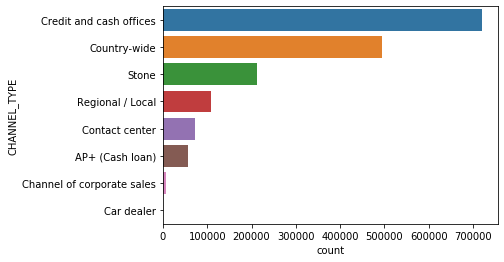

In [127]:
sns.countplot(y=previous_app['CHANNEL_TYPE'],
              order=previous_app['CHANNEL_TYPE'].value_counts().index)

# 分割支払のデータ探索
## 分割支払データの概観

In [128]:
installment = pd.read_csv('input/installments_payments.csv')

In [129]:
installment.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [130]:
installment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


おわり